# Nama : Ahmad Raihan
# Project : Food Vision 101

## 1. Data Understanding

### 1.1 Import Library

In [35]:
# Import library
import os
import math
import datetime

## Library Visualisasi Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Library Deep Learning
import tensorflow_datasets as tfds
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import tensorflow as tf

### 1.2. Download Data

In [2]:
# Load dataset makanan (food101) yang ada dari tensorflow_datasets
(train_data, val_data, test_data), ds_info = tfds.load(name='food101',
                                                       split=['train', 'validation[:50%]', 'validation[50%:]'],
                                                       shuffle_files=True,
                                                       as_supervised=True,
                                                       with_info=True)

print(f'Jumlah data training : {len(train_data)}, data validation : {len(val_data)}, dan data test : {len(test_data)}')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.2C8BHO_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.2C8BHO_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
Jumlah data training : 75750, data validation : 12625, dan data test : 12625


### 1.3 EDA (Eksploratory Data Analysis)

In [3]:
# Melihat class name dengan mengambil dari ds_info

print(f'Isi dari feature dari ds_info: \n{ds_info.features}')

class_names = ds_info.features['label'].names
print(f'\n10 kelas dari 101 kelas makanan adalah : {class_names[:10]}')

Isi dari feature dari ds_info: 
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

10 kelas dari 101 kelas makanan adalah : ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [4]:
# Melihat data misal diambil dari train_data

print(f'Tipe data dari train_data yang diambil dari tensorflow_datasets adalah --> "{type(train_data)}"')

unique_labels = set()
images_list = []
labels_list = []

for images, labels in train_data:
  label_name = class_names[labels.numpy()]        # ubah label dalam bentuk tensor ke label biasa agar bisa dimasukkan ke dalam set

  if label_name not in unique_labels:
    unique_labels.add(label_name)
    images_list.append(images)
    labels_list.append(label_name)

  if len(unique_labels) == len(class_names):
    break

Tipe data dari train_data yang diambil dari tensorflow_datasets adalah --> "<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>"


Masukkan jumlah gambar yang ingin divisualisasikan: 12


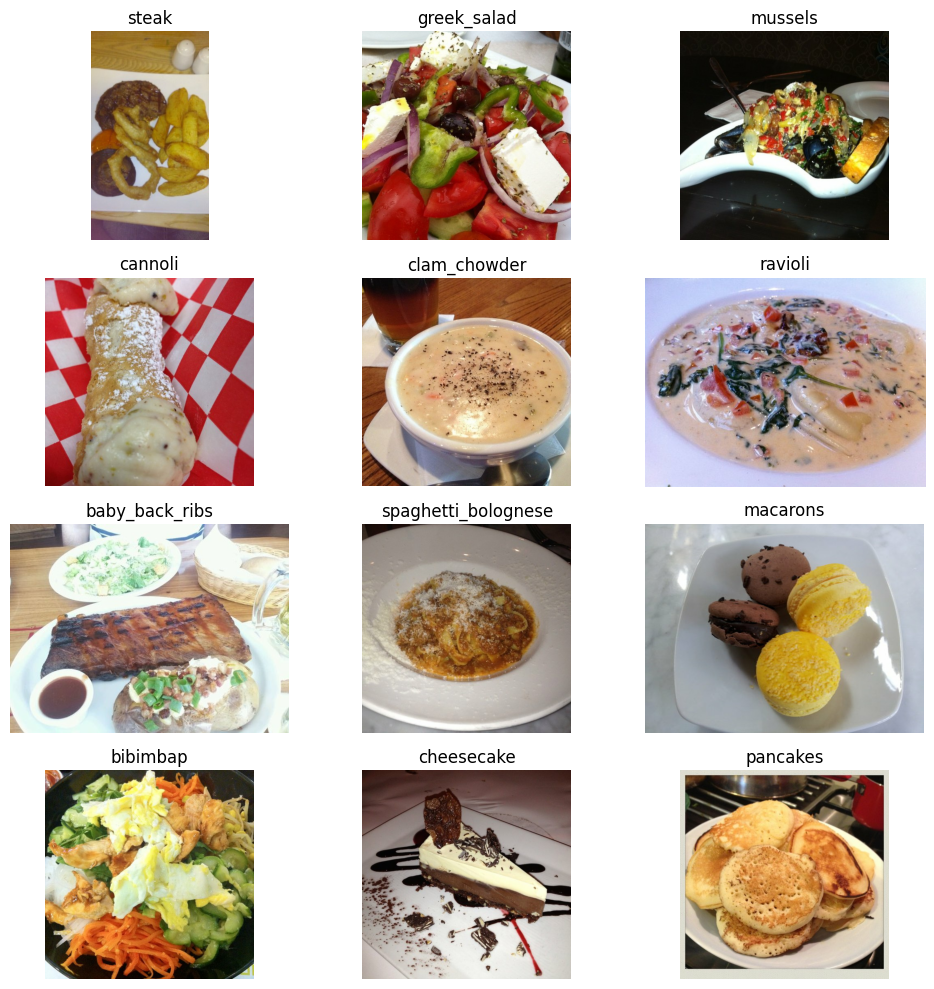

In [5]:
# Visualisasi data

jumlah_visualisasi = int(input('Masukkan jumlah gambar yang ingin divisualisasikan: '))
plt.figure(figsize=(10,10))
ncols = 3
nrows = math.ceil(jumlah_visualisasi/ncols)

for i in range(jumlah_visualisasi):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(images_list[i])
  plt.title(f'{labels_list[i]}')
  plt.axis('off')

plt.tight_layout()
plt.show()

## 2. Data Preparation
- Berdasarkan hasil dari pengenalan data terdapat keanehan dari preprocessing otomatisnya dimana
1. Tipe data dari image yang digunakan uint8
2. Ukuran dari gambar beragam
3. Gambar belum di rescale

- Maka dari itu kita perlu melakukan preprocessing pada data dengan membuat fungsi agar
1. Tipe data dari image berubah menjadi float
2. Ukuran dari gambar sama yaitu 224,224,3
3. Gambar sudah direscale (optional tergantung model yang digunakan)

In [6]:
def preprocesing_image(image, label, img_size=224):
  image = tf.image.resize(image, [img_size,img_size])     # resize
  image = tf.cast(image, dtype=tf.float32)                # convert type data
  # image = image/255.                                    # optional rescale
  return image, label

In [7]:
# Melakukan preprocessing dengan fungsi diatas
train_data = train_data.map(map_func=preprocesing_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=500).batch(batch_size=16).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.map(map_func=preprocesing_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=16).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.map(map_func=preprocesing_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=16).prefetch(buffer_size=tf.data.AUTOTUNE)

## 3. Modeling

In [ ]:
# Membangun dan latih model dengan feature extraction sebelum fine tuning

## 1. hidupkan mixed precesion training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

## 2. Inisiasi model transfer learning
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

## 3. Inisiasi data augmentasi sebagai layer
augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

## 4. Membangun arsitektur model
input_layer = tf.keras.layers.Input(shape=(224,224,3))
x = augmentation_layer(input_layer)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(units=256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(units=101)(x)
output_layer = tf.keras.layers.Activation(activation='softmax', dtype=tf.float32, name='softmax_float32')(x)

model = tf.keras.Model(input_layer, output_layer)

## 5. Bungkus optimizer seperti Adam, sgd, dsb dengan LossScaleOptimizer
base_optimizer = tf.keras.optimizers.Adam()

## 6. Melakukan kompilasi model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

## 6. Melihat arsitektur yang telah dibuat
model.summary()

In [ ]:
# Melatih model
initial_epochs=10

history_pre_fine_tune = model.fit(train_data,
                                  epochs=initial_epochs,
                                  steps_per_epoch=len(train_data),
                                  validation_data=val_data,
                                  validation_steps=len(val_data))

In [ ]:
# Melatih model dengan metode fine tuning

## 1. Unfreeze 50 layer terakhir
base_model.trainable = True
for layer in base_model.layers[:-50]:
  layer.trainable = False

## 2. Kompilasi ulang modelnya dengan
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

In [ ]:
# Latih modelnya
history_fine_tuning = model.fit(train_data,
                                epochs=initial_epochs+10,
                                steps_per_epoch=len(train_data),
                                validation_data=val_data,
                                validation_steps=len(val_data),
                                initial_epoch=history_pre_fine_tune.epoch[-1])

Epoch 10/20
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 383s 76ms/step - accuracy: 0.3998 - loss: 2.5325 - val_accuracy: 0.6659 - val_loss: 1.2483
Epoch 11/20
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 360s 76ms/step - accuracy: 0.5021 - loss: 1.9712 - val_accuracy: 0.6864 - val_loss: 1.1595
Epoch 12/20
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 358s 75ms/step - accuracy: 0.5234 - loss: 1.8769 - val_accuracy: 0.6981 - val_loss: 1.1072
Epoch 13/20
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 369s 78ms/step - accuracy: 0.5412 - loss: 1.8033 - val_accuracy: 0.7054 - val_loss: 1.0725
Epoch 14/20
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 360s 73ms/step - accuracy: 0.5508 - loss: 1.7421 - val_accuracy: 0.7125 - val_loss: 1.0381
Epoch 15/20
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 367s 77ms/step - accuracy: 0.5636 - loss: 1.7068 - val_accuracy: 0.7217 - val_loss: 1.0117
Epoch 16/20
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 355s 75ms/step - accuracy: 0.5744 - loss: 1.6650 - val_accuracy: 0.7231 - val_loss: 0.9914
Epoch 17/20
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 398s 78ms/step - ac

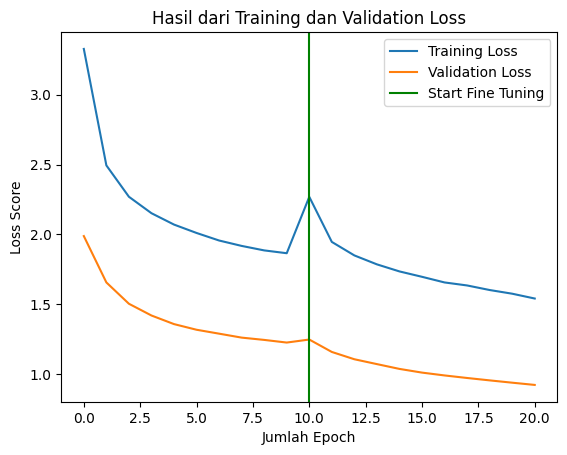

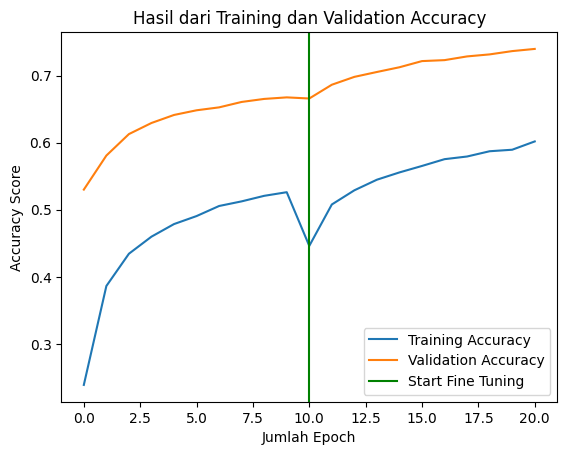

In [ ]:
# Visualisasi Data
def evaluation_graph_model(history_before, history_after, initial_epochs=10):
  loss = history_before.history['loss'] + history_after.history['loss']
  val_loss = history_before.history['val_loss'] + history_after.history['val_loss']
  acc = history_before.history['accuracy'] + history_after.history['accuracy']
  val_acc = history_before.history['val_accuracy'] + history_after.history['val_accuracy']

  # Plot line_plot
  plt.figure()
  plt.plot(loss,label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.axvline(initial_epochs, label='Start Fine Tuning', color='green')
  plt.title('Hasil dari Training dan Validation Loss')
  plt.xlabel('Jumlah Epoch')
  plt.ylabel('Loss Score')
  plt.legend()

  plt.figure()
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.axvline(initial_epochs, label='Start Fine Tuning', color='green')
  plt.title('Hasil dari Training dan Validation Accuracy')
  plt.xlabel('Jumlah Epoch')
  plt.ylabel('Accuracy Score')
  plt.legend()

evaluation_graph_model(history_pre_fine_tune, history_fine_tuning)

In [ ]:
# Simpan Modelnya
model.save('model_klasifikasi_makanan.keras')

# **4. Evaluasi Model pada Data Test**

In [8]:
# Memuat model terbaik
loaded_model = tf.keras.models.load_model('model_klasifikasi_makanan.keras')
loaded_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 51 variables whereas the saved optimizer has 104 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 101)            │        25,957 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_2 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,284,223 (27.79 MB)

 Trainable params: 2,880,757 (10.99 MB)

 Non-trainable params: 1,522,707 (5.81 MB)

 Optimizer params: 2,880,759 (10.99 MB)

In [9]:
# Uji Loss dan Akurasi Klasifikasi pada data test
loss, acc = loaded_model.evaluate(test_data)
print(f'Loss Model pada data Test adalah {loss}')
print(f'Akurasi Model pada data Test adalah {acc}')

790/790 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.7400 - loss: 0.9259
Loss Model pada data Test adalah 0.9325597882270813
Akurasi Model pada data Test adalah 0.7376633882522583


In [32]:
# Mengambil y_true (true_labels) dan y_pred (pred_class)

true_labels = []
preds_class = []

for batch in test_data:
    x, y = batch
    pred = loaded_model.predict(x, verbose=0)
    preds_class.extend(np.argmax(pred, axis=1))
    true_labels.extend(y.numpy())

In [40]:
accuracy = accuracy_score(true_labels, preds_class)
precision, recall, f1_score,_ = precision_recall_fscore_support(true_labels, preds_class, average='weighted')

evaluate_df = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1-Score': [f1_score]
}, index=['Efficient-Net Model'])

evaluate_df

,Accuracy,Precision,Recall,F1-Score
Efficient-Net Model,0.737663,0.738318,0.737663,0.734476
